In [1]:
import numpy as np 
import seaborn as sns
import pandas as pd
import astropy
from astropy.io import fits
from astropy.modeling import models, fitting
from multiprocessing import Pool, cpu_count
from sklearn.metrics import mean_squared_error  
from scipy import stats
from numba import jit
from graph_tool.all import *
from typing import Tuple, List
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse, Circle


plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 
          'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 
          'xkcd:teal', 'xkcd:goldenrod', 'xkcd:cadet blue', 'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256)))

bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

# Reading FITS files

In [3]:
fits_type = astropy.io.fits.hdu.hdulist.HDUList
def get_fits_file(wavelen: str,
                  fits_path: str = '../Data/FITS/') -> Tuple[fits_type,
                                                             np.ndarray]:
    """
    wavelen in ['f606w', 'f814w']
    """
    files = os.listdir(fits_path)
    file = [file for file in files if file.split('_')[-3] == wavelen][0]
    fits_obj = fits.open(fits_path + file)
    image = fits_obj[0].data
    return fits_obj, image


# Get images as 2-D numpy array from FITS file of F606w and F818w
fits_f606, image_f606 = get_fits_file('f606w')
fits_f814, image_f814 = get_fits_file('f814w')



# info about F606w fits file
print(fits_f606.info())

# info about F814w fits file
print(fits_f814.info())

Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_f606w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7127   (10510, 10403)   float32   
None
Filename: ../Data/FITS/hlsp_deep47tuc_hst_acs_47tuc_f814w_v1_drz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    7595   (10065, 10395)   float32   
None


Filter out all negative values for the intensity because they don't have physical meaning.

In [4]:
# Take for example image of f606 wavelen
image = np.copy(image_f606)

# Check how many negative values are there
print(len(image[image < 0]) / len(image.flatten()))

# setting to 0 all negative values
image[image < 0] = 0

0.15048535457778456


Read stars dataset.

In [5]:
names = ['ID', 'Xcor', 'Ycor', 'F606', 'eF606',
         'F814', 'eF814', 'chi', 'sharp']


def get_data(data_path: str = '../Data/Catalog/',
             names: List[str] = names) -> pd.DataFrame:
    file = os.listdir(data_path)[0]
    df = pd.read_csv(data_path + file, names=names,
                     delim_whitespace=True, skiprows=1)
    return df


original = get_data()
data = original.copy()
data

,ID,Xcor,Ycor,F606,eF606,F814,eF814,chi,sharp
0,8,4462.947,140.859,28.197,0.1036,27.127,0.1068,6.106,0.7310
1,120,5002.486,186.138,20.843,0.0552,19.815,0.0661,10.690,0.4000
2,165,5003.574,195.421,27.014,0.2194,26.068,0.1349,10.651,0.1940
3,226,4448.493,207.417,30.193,0.3641,28.270,0.1636,4.059,-1.9585
4,351,5040.717,224.366,28.935,0.1669,28.941,0.2464,4.274,-0.7720
...,...,...,...,...,...,...,...,...,...
51475,899987,3417.467,10394.319,26.895,0.0783,25.602,0.1050,9.508,1.3140
51476,900088,3435.031,10396.730,23.152,0.0504,22.662,0.0505,8.823,-0.1330
51477,900094,3594.567,10397.340,27.209,0.0815,27.130,0.0900,4.311,0.9355
51478,900176,5155.093,10397.920,28.235,0.0984,26.477,0.0937,6.173,0.3190


Find all image points with intensity values in a choosen range.

In [6]:
def find_coord(inf: int, sup: int, image: np.ndarray = image) -> np.ndarray:
    idys, idxs = np.where((image > inf) & (image < sup))
    ids = np.array((idxs, idys)).T
    return ids.astype(np.float64)

In [7]:
%%time

ids = find_coord(950, 1000)
ids.shape

CPU times: user 328 ms, sys: 172 ms, total: 500 ms
Wall time: 503 ms


(39081, 2)

 Plotting comparison between all stars and filtered ones.

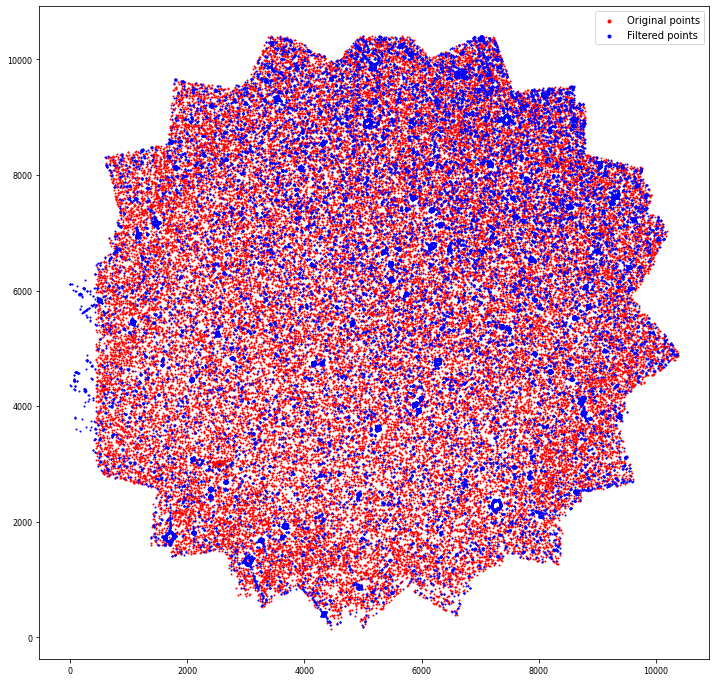

In [8]:
plt.figure(figsize=(12, 12))
plt.scatter(data['Xcor'], data['Ycor'], s=1, c='r', label='Original points')
plt.scatter(ids[:,0], ids[:,1], s=1, c='b', label='Filtered points')
plt.legend(markerscale=3)
#plt.xlim(0, 2000)
#plt.ylim(1250, 2000)

In order to further filter the points and find isolated stars, we use graph-tool package. 
Create a geometric graph where all the coordinates found before are vertices. This points are connected in an euclidean space which are at a distance equal to or smaller than a given radius.

In [9]:
%%time

bb = 15.
dist = np.sqrt(2) * bb
g, pos = geometric_graph(ids, dist) 
g.vp['pos'] = pos
a = g.vp.pos.get_2d_array([0, 1]).T
a[:,1] = -a[:,1]
vis = g.new_vp('vector<double>', vals=a)
g.vp.vis = vis

g

CPU times: user 1.16 s, sys: 93.8 ms, total: 1.25 s
Wall time: 247 ms


<Graph object, undirected, with 39081 vertices and 223414 edges, 2 internal vertex properties, at 0x7f1b3b8209d0>

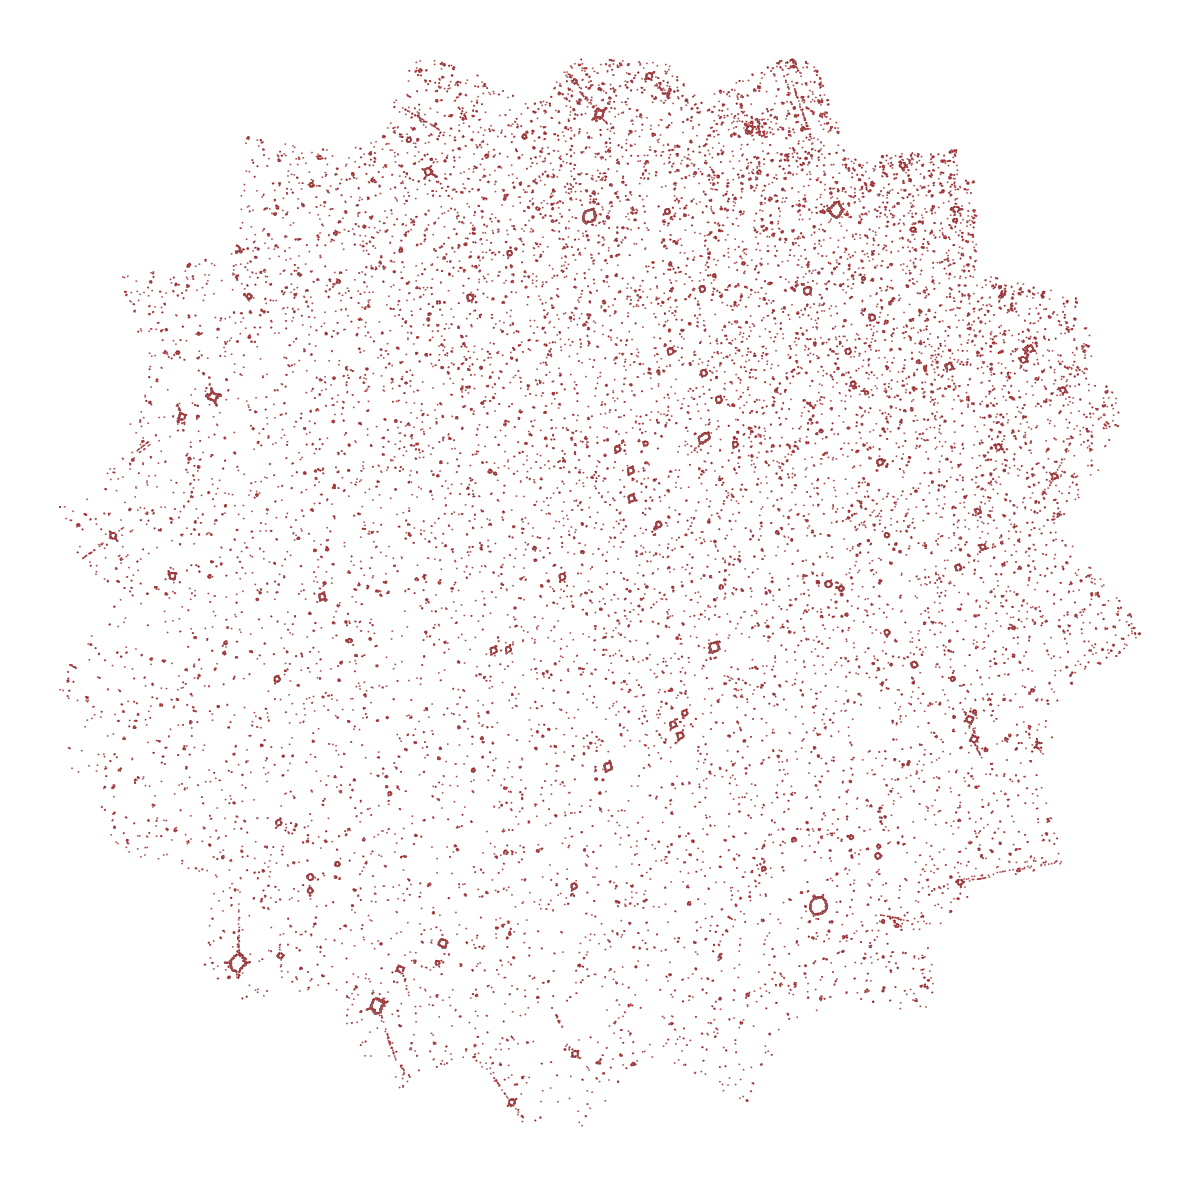

CPU times: user 3.64 s, sys: 172 ms, total: 3.81 s
Wall time: 3.81 s


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1b3b8209d0, at 0x7f1b3b886dc0>

In [10]:
%%time

graph_draw(g, g.vp.vis)

In [11]:
%%time

# Filter out all vertices with at least 1 edge.
gv = GraphView(g, vfilt=g.degree_property_map("out").a==0)
gv

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.71 ms


<GraphView object, undirected, with 4017 vertices and 0 edges, 2 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f1b3b820df0, at 0x7f1b3b81f280>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f1b3b820df0, at 0x7f1b3b820ee0>, False), at 0x7f1b3b820df0>

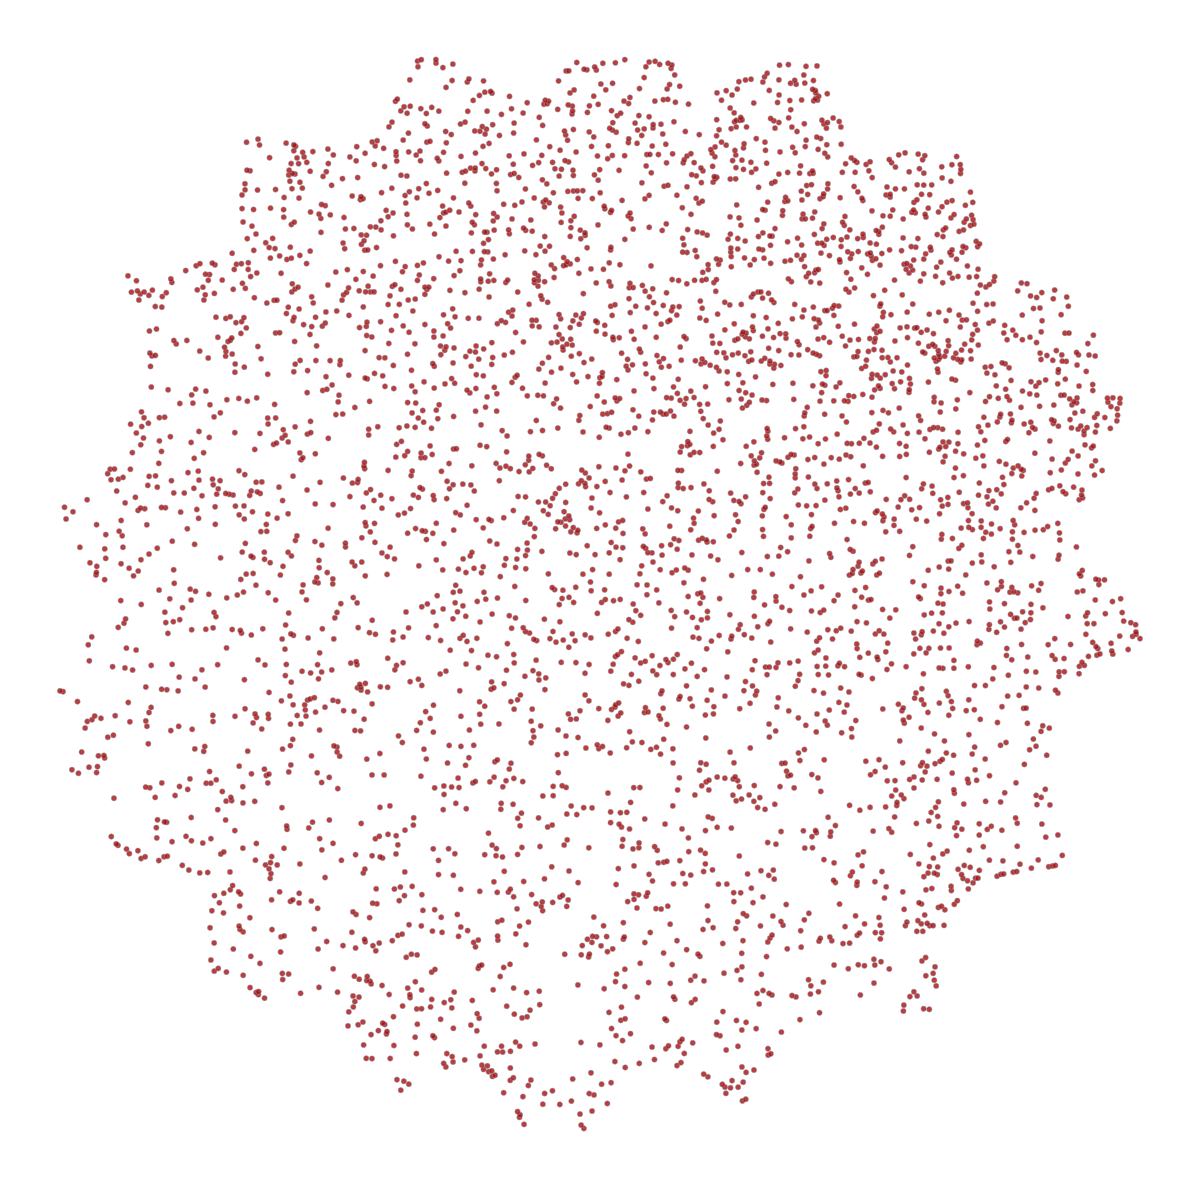

CPU times: user 188 ms, sys: 0 ns, total: 188 ms
Wall time: 186 ms


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f1b3b820df0, at 0x7f1b3b886df0>

In [12]:
%%time

graph_draw(gv, gv.vp.vis)

In [13]:
%%time

ids_filt = gv.vp.pos.get_2d_array([0, 1]).T

del g, gv

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.62 ms


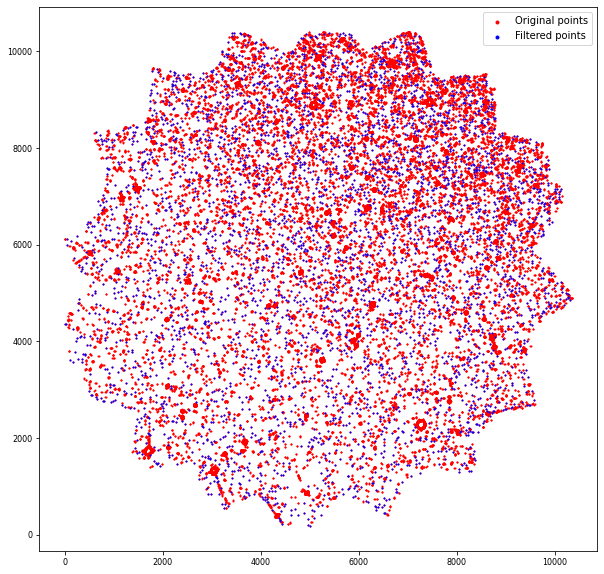

In [14]:
plt.figure(figsize=(10,10))
plt.scatter(ids[:,0], ids[:,1], s=1, c='r', label='Original points')
plt.scatter(ids_filt[:,0], ids_filt[:,1], s=1, c='b', label='Filtered points')
plt.legend(markerscale=3)
#plt.xlim(0, 2000)
#plt.ylim(1250, 2000)

Find all stars ID in the dataset corresponding to an intesity value in a given range.

In [15]:
def find_IDs(coords: np.ndarray, ids: np.ndarray, npix: float) -> List[float]:
    IDs = []
    n = len(ids)
    for i in range(n):
        tmp = (coords[:,0] - ids[i,0]) ** 2 + \
              (coords[:,1] - ids[i,1]) ** 2 <= npix ** 2
        boh = np.sum(tmp)
        if boh:
            for j in coords[tmp, -1]:
                IDs.append([j, ids[i,0], ids[i,1]]) # se uso *ids[i,:] conflitto con jit
    return IDs


find_IDs_jit = jit(nopython=True)(find_IDs) # not working rn
cor = data[['Xcor', 'Ycor', 'ID']].to_numpy()

In [16]:
%%time


IDs = find_IDs(cor, ids, 2.)
len(IDs)

CPU times: user 5.22 s, sys: 62.5 ms, total: 5.28 s
Wall time: 5.28 s


2748

In [17]:
len(ids), len(ids_filt)

(39081, 4017)

In [18]:
%%time

#cor = data[['Xcor', 'Ycor', 'ID']].to_numpy()
IDs = find_IDs_jit(cor, ids, 2.)
#len(IDs)

CPU times: user 2.08 s, sys: 31.2 ms, total: 2.11 s
Wall time: 2.09 s


In [19]:
print(len(IDs) / len(ids))
np.unique(np.unique(IDs, return_counts=True)[1], return_counts=True)

0.07031549857987257


(array([1, 2, 3, 4, 5, 6, 7]),
 array([5080, 1124,  230,   34,   14,    1,    2]))

In [20]:
a = np.asarray(IDs)
a.shape

(2748, 3)

In [21]:
%%time


IDs_filt = find_IDs(cor, ids_filt, 2.)
len(IDs_filt)

CPU times: user 625 ms, sys: 0 ns, total: 625 ms
Wall time: 632 ms


1182

In [22]:
%%time

#cor = data[['Xcor', 'Ycor', 'ID']].to_numpy()
IDs_filt = find_IDs_jit(cor, ids_filt, 2.)
len(IDs_filt)

CPU times: user 172 ms, sys: 0 ns, total: 172 ms
Wall time: 174 ms


1182

In [43]:
ids_gt = np.asarray(IDs_filt)
ids_gt.shape

(1182, 3)

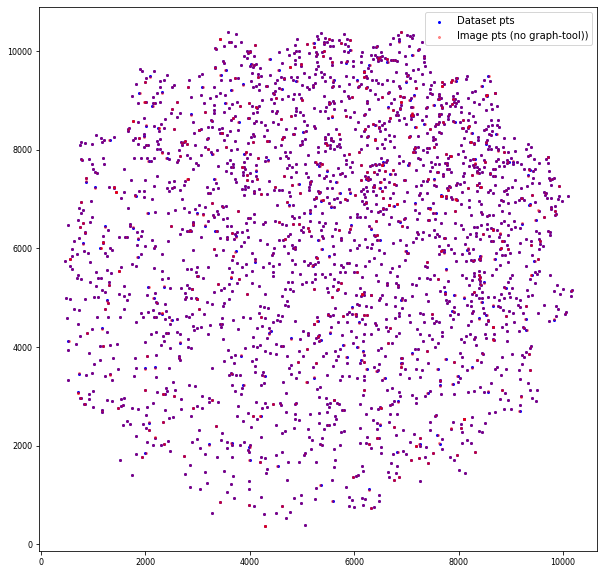

In [33]:
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.scatter(data.loc[data.ID.isin(a[:, 0]), 'Xcor'], 
            data.loc[data.ID.isin(a[:, 0]), 'Ycor'],
            color='b', s=4, label='Dataset pts')
plt.scatter(a[:,1], a[:,2], alpha=0.4, color='r', s=4, label='Image pts (no graph-tool))')
plt.legend()

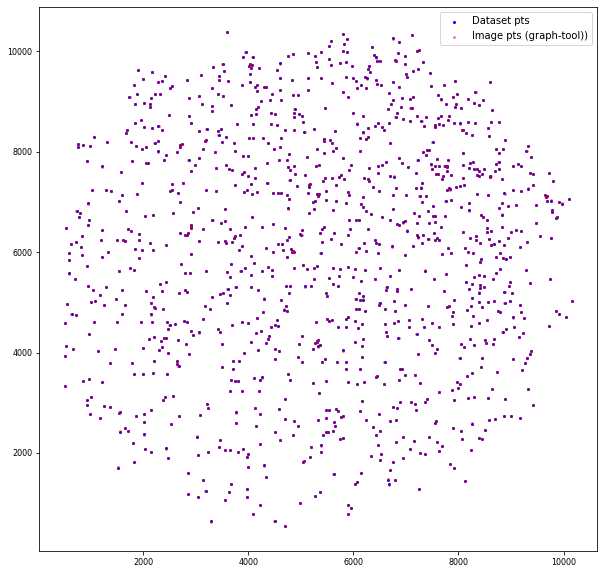

In [34]:
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.scatter(data.loc[data.ID.isin(ids_gt[:, 0]), 'Xcor'], 
            data.loc[data.ID.isin(ids_gt[:, 0]), 'Ycor'],
            color='b', s=4, label='Dataset pts')
plt.scatter(ids_gt[:,1], ids_gt[:,2], alpha=0.4, color='r', s=4, label='Image pts (graph-tool))')
plt.legend()

In [26]:
print(np.unique(np.unique(a[:,0], return_counts=True)[1], return_counts=True))
np.unique(np.unique(a_filt[:,0], return_counts=True)[1], return_counts=True) 

(array([1, 2, 3, 4]), array([2210,  249,   12,    1]))


(array([1]), array([1182]))

# Gaussian fitting with max intensity at center

In [73]:
def gauss_fitting(id: float, ids: np.ndarray = ids_gt, 
                  img: np.ndarray = image, bb: int = 15) -> np.array:
    """
    Parameters
    ----------
    id     : star id
    ids_gt : id of all filtered stars 
    img    : data from fits file
    bb     : half side of the squared box
    Returns
    -------
    star ID, fit init paramteres, best fit parameters and rms
    """   
    xc, yc = np.int32(ids[ids[:,0] == id, 1:].flatten())
    mat = img.copy() 
    box = mat[yc - bb:yc + bb, xc - bb: xc + bb]
    Ai = np.max(box)
    xi = xc - bb + np.where(box == Ai)[1][0]
    yi = yc - bb + np.where(box == Ai)[0][0]
    
    # check if max intensity is at central pixel
    if [xc, yc] != [xi, yi]:
        box = mat[yi - bb: yi + bb, xi - bb: xi + bb]
        xc, yc = xi, yi
        
    box /= Ai
    yp, xp = box.shape 
    y, x = np.mgrid[:yp, :xp]
   
    # Fitting
    fit = fitting.LevMarLSQFitter()   
    fi = models.Gaussian2D(amplitude=1., x_mean=bb, y_mean=bb,
                            x_stddev=1, y_stddev=1, theta=0)
    f = fit(fi, x, y, box)
    # Best fit parameters
    A = f.amplitude[0]
    x0 = xc - bb + f.x_mean[0]
    y0 = yc - bb + f.y_mean[0]
    sigma_x = f.x_stddev[0]
    sigma_y = f.y_stddev[0]
    theta = f.theta[0]
    # Compute the mean squared error
    rms = mean_squared_error(box, f(x, y), squared=False)
    return np.array([id, Ai, xi, yi, A, x0, y0, sigma_x, sigma_y, theta, rms])

In [74]:
%%time

p = Pool(cpu_count())
res = np.asarray(p.map(gauss_fitting, ids_gt[:,0]))
p.close()
results = pd.DataFrame(res, columns=['ID', 'Ai', 'xi', 'yi', 'A', 'x0','y0',
                                     'sigma_x', 'sigma_y', 'theta', 'rms'])

CPU times: user 328 ms, sys: 1.33 s, total: 1.66 s
Wall time: 1min 34s


In [75]:
results

,ID,Ai,xi,yi,A,x0,y0,sigma_x,sigma_y,theta,rms
0,7873.0,2357.616699,4702.0,540.0,0.868686,4701.741504,540.711522,1.589817,1.717301,1.488111,0.010640
1,12547.0,987.621582,3284.0,633.0,0.803173,3283.582631,633.302088,2.031004,1.589944,-0.597083,0.029983
2,13066.0,3535.371094,4497.0,642.0,0.810296,4497.611957,642.160301,1.604633,1.481047,-0.212273,0.015547
3,23114.0,1189.529907,4083.0,770.0,0.926886,4082.361297,770.063999,1.135193,1.148767,0.450874,0.041796
4,23342.0,1122.490845,5890.0,783.0,0.993879,5890.729878,782.171656,1.579409,1.667436,0.079307,0.028096
...,...,...,...,...,...,...,...,...,...,...,...
1177,893600.0,1085.983887,5869.0,10241.0,0.760044,5869.104249,10241.733461,1.883473,1.578987,5.546246,0.042944
1178,894495.0,1056.371582,6753.0,10258.0,0.851426,6752.555043,10257.188439,1.694519,1.596119,2.659499,0.058658
1179,897539.0,1573.232666,7123.0,10322.0,0.910377,7123.027942,10322.104568,1.839167,1.692269,-0.510299,0.048671
1180,898640.0,957.354309,5807.0,10352.0,0.963499,5807.025492,10352.136560,1.767924,1.488765,2.324275,0.036226


In [76]:
results[results.Ai > 1000]

,ID,Ai,xi,yi,A,x0,y0,sigma_x,sigma_y,theta,rms
0,7873.0,2357.616699,4702.0,540.0,0.868686,4701.741504,540.711522,1.589817,1.717301,1.488111,0.010640
2,13066.0,3535.371094,4497.0,642.0,0.810296,4497.611957,642.160301,1.604633,1.481047,-0.212273,0.015547
3,23114.0,1189.529907,4083.0,770.0,0.926886,4082.361297,770.063999,1.135193,1.148767,0.450874,0.041796
4,23342.0,1122.490845,5890.0,783.0,0.993879,5890.729878,782.171656,1.579409,1.667436,0.079307,0.028096
7,41285.0,5857.016113,4216.0,964.0,0.869766,4215.983803,964.282898,1.500589,1.573508,7.386534,0.010916
...,...,...,...,...,...,...,...,...,...,...,...
1176,892180.0,1579.990723,5577.0,10216.0,0.730657,5577.800398,10216.387447,2.348847,2.037618,-0.075431,0.066416
1177,893600.0,1085.983887,5869.0,10241.0,0.760044,5869.104249,10241.733461,1.883473,1.578987,5.546246,0.042944
1178,894495.0,1056.371582,6753.0,10258.0,0.851426,6752.555043,10257.188439,1.694519,1.596119,2.659499,0.058658
1179,897539.0,1573.232666,7123.0,10322.0,0.910377,7123.027942,10322.104568,1.839167,1.692269,-0.510299,0.048671


In [77]:
results['sharp'] = results.ID.map(data.set_index('ID')['sharp'])
results['chi'] = results.ID.map(data.set_index('ID')['chi'])
results.loc[results.theta > 0, 'theta_mod'] = results.loc[results.theta > 0,
                                                          'theta'] % np.pi/2
results.loc[results.theta <= 0, 'theta_mod'] = results.loc[results.theta <= 0,
                                                           'theta'] % -np.pi/2

results

,ID,Ai,xi,yi,A,x0,y0,sigma_x,sigma_y,theta,rms,sharp,chi,theta_mod
0,7873.0,2357.616699,4702.0,540.0,0.868686,4701.741504,540.711522,1.589817,1.717301,1.488111,0.010640,0.293,6.8885,0.744055
1,12547.0,987.621582,3284.0,633.0,0.803173,3283.582631,633.302088,2.031004,1.589944,-0.597083,0.029983,0.363,10.5260,-0.298541
2,13066.0,3535.371094,4497.0,642.0,0.810296,4497.611957,642.160301,1.604633,1.481047,-0.212273,0.015547,0.154,7.6380,-0.106136
3,23114.0,1189.529907,4083.0,770.0,0.926886,4082.361297,770.063999,1.135193,1.148767,0.450874,0.041796,0.083,10.3355,0.225437
4,23342.0,1122.490845,5890.0,783.0,0.993879,5890.729878,782.171656,1.579409,1.667436,0.079307,0.028096,-0.122,10.2240,0.039654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,893600.0,1085.983887,5869.0,10241.0,0.760044,5869.104249,10241.733461,1.883473,1.578987,5.546246,0.042944,-0.071,9.8750,1.202327
1178,894495.0,1056.371582,6753.0,10258.0,0.851426,6752.555043,10257.188439,1.694519,1.596119,2.659499,0.058658,0.057,9.1160,1.329750
1179,897539.0,1573.232666,7123.0,10322.0,0.910377,7123.027942,10322.104568,1.839167,1.692269,-0.510299,0.048671,0.001,6.2480,-0.255149
1180,898640.0,957.354309,5807.0,10352.0,0.963499,5807.025492,10352.136560,1.767924,1.488765,2.324275,0.036226,-0.024,12.1230,1.162137


<AxesSubplot:ylabel='Frequency'>

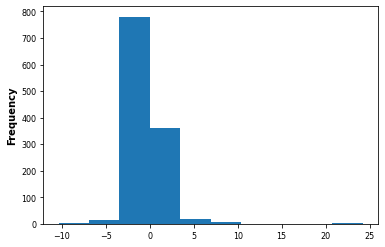

In [78]:
results.theta.plot(kind='hist')

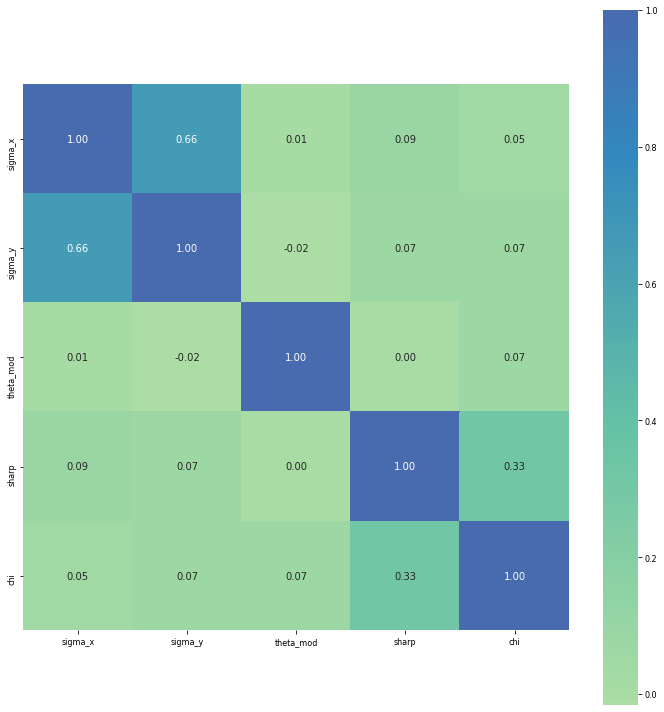

In [79]:
cols = ['sigma_x', 'sigma_y', 'theta_mod', 'sharp', 'chi']

plt.figure(figsize=(10,10))
cm = np.corrcoef(results[cols].to_numpy().T)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 10},
                 yticklabels=cols,
                 xticklabels=cols,
                 cmap = cmap)
plt.tight_layout();